# Demo: guided proposal for radial Ornstein-Uhlenbeck bridge 

In [3]:
import numpy as np
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from scipy.special import iv, ivp
from torch.distributions.gamma import Gamma
plt.style.use("ggplot")
from DiffusionBridge.utils import normal_logpdf


In [260]:
# problem settings
d = 1
theta = torch.tensor(4.0)
f = lambda t, x: theta / x - x
sigma = torch.tensor(1.0)
T = torch.tensor(8.0)
M = 400
diffusion = db.diffusion.model(f, sigma, d, T, M)

# transition density
log_transition_density = (
    lambda t, x, x0: theta * torch.log(x / x0)
    + 0.5 * torch.log(x * x0)
    - x**2
    + (theta + 0.5) * t
    - torch.log(torch.sinh(t))
    - (x**2 + x0**2) / (torch.exp(2.0 * t) - 1.0)
    + torch.log(iv(theta - 0.5, x * x0 / torch.sinh(t)))
)

score_transition = (
    lambda t, x, x0: theta / x
    + 1.0 / (2.0 * x)
    - 2.0 * x
    - 2.0 * x / (torch.exp(2.0 * t) - 1.0)
    + (1.0 / iv(theta - 0.5, x * x0 / torch.sinh(t)))
    * ivp(theta - 0.5, x * x0 / torch.sinh(t))
    * x0
    / torch.sinh(t)
)

# h-transform
grad_logh = (
    lambda t, x, xT: -theta / x
    + 1.0 / (2.0 * x)
    - 2.0 * x / (torch.exp(2.0 * (T - t)) - 1.0)
    + (1.0 / iv(theta - 0.5, xT * x / torch.sinh(T - t)))
    * ivp(theta - 0.5, xT * x / torch.sinh(T - t))
    * xT
    / torch.sinh(T - t)
)

# score marginal
score_marginal = lambda t, x, x0, xT: score_transition(t, x, x0) + grad_logh(t, x, xT)

# Backward diffusion bridge with score matching

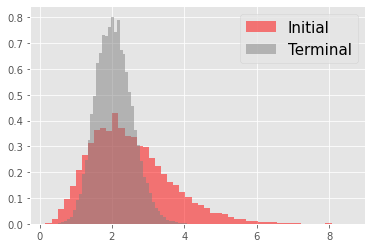

In [261]:
# plot initial and terminal distributions
distribution_X0 = Gamma(torch.tensor(5.0), torch.tensor(2.0))
simulate_X0 = lambda N: distribution_X0.sample((N,)).reshape(N, d)
N = 2**14
trajectories = diffusion.simulate_process(simulate_X0(N))["trajectories"]
plt.hist(trajectories[:, 0, 0].numpy(), bins=50, density=True, color="red", alpha=0.5)
plt.hist(trajectories[:, M, 0].numpy(), bins=50, density=True, color="grey", alpha=0.5)
plt.legend(["Initial", "Terminal"], fontsize=15)
plt.show()

In [262]:
# learn backward diffusion bridge process with score matching
distribution_X0 = Gamma(torch.tensor(5.0), torch.tensor(2.0))
simulate_X0 = lambda N: distribution_X0.sample((N,)).reshape(N, d)
XT = []
epsilon = 1.0
minibatch = 1
num_initial_per_batch = 100
num_iterations = 1000
learning_rate = 0.01
ema_momentum = 0.99

output = diffusion.learn_full_score_transition(
    simulate_X0,
    XT,
    epsilon,
    minibatch,
    num_initial_per_batch,
    num_iterations,
    learning_rate,
    ema_momentum,
)
score_transition_net = output["net"]
loss_values_transition = output["loss"]

Optimization iteration: 1 Loss: 48.78646469116211
Optimization iteration: 50 Loss: 45.24237060546875
Optimization iteration: 100 Loss: 45.464263916015625
Optimization iteration: 150 Loss: 45.333675384521484
Optimization iteration: 200 Loss: 45.074527740478516
Optimization iteration: 250 Loss: 45.67072677612305
Optimization iteration: 300 Loss: 45.79130554199219
Optimization iteration: 350 Loss: 45.90967559814453
Optimization iteration: 400 Loss: 45.363582611083984
Optimization iteration: 450 Loss: 45.26949691772461
Optimization iteration: 500 Loss: 45.655662536621094
Optimization iteration: 550 Loss: 45.269588470458984
Optimization iteration: 600 Loss: 45.82787322998047
Optimization iteration: 650 Loss: 45.44466018676758
Optimization iteration: 700 Loss: 45.50825119018555
Optimization iteration: 750 Loss: 45.14739227294922
Optimization iteration: 800 Loss: 45.76108932495117
Optimization iteration: 850 Loss: 45.4761848449707
Optimization iteration: 900 Loss: 45.786685943603516
Optimizat

In [266]:
# initial and terminal constraints
# X0 = 1.5 * torch.ones(d)
# XT = 1.0 * torch.ones(d)
# X0 = 1.5 * torch.ones(d)
# XT = 2.5 * torch.ones(d)
X0 = 3.0 * torch.ones(d)
XT = 4.0 * torch.ones(d)
print("true log-transition density: " + str(float(log_transition_density(T, XT, X0))))

# simulate diffusion bridge process backwards using approximate score
epsilon = 1.0
N = 2**10
num_steps = None
# num_steps = int(2 * M)
with torch.no_grad():
    output = diffusion.simulate_bridge_backwards(
        score_transition_net,
        X0,
        XT,
        epsilon,
        N,
        modify=True,
        full_score=True,
        new_num_steps=num_steps,
    )
    trajectories = output["trajectories"]
    log_proposal = output["logdensity"]

# importance sampling
log_target = diffusion.law_bridge(trajectories, new_num_steps=num_steps)
log_weights = log_target - log_proposal
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
print("log-transition density: " + str(float(log_transition_estimate)))
print("ESS%: " + str(float(ess * 100 / N)))

# independent Metropolis-Hastings
initial = diffusion.simulate_bridge_backwards(
    score_transition_net,
    X0,
    XT,
    epsilon,
    1,
    modify=True,
    full_score=True,
    new_num_steps=num_steps,
)
current_trajectory = initial["trajectories"]
current_log_proposal = initial["logdensity"]
current_log_target = diffusion.law_bridge(current_trajectory, new_num_steps=num_steps)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if torch.log(torch.rand(1)) < log_accept_prob:
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()
        num_accept += 1
accept_rate = num_accept / N
print("Acceptance rate: " + str(float(accept_rate)))

true log-transition density: -6.670233726501465
log-transition density: -6.584484100341797
ESS%: 90.81828308105469
Acceptance rate: 0.83984375


# Guided proposal process

In [275]:
# initial and terminal constraints
# X0 = 1.5 * torch.ones(d)
# XT = 1.0 * torch.ones(d)
X0 = 1.5 * torch.ones(d)
XT = 2.5 * torch.ones(d)
# X0 = 3.0 * torch.ones(d)
# XT = 4.0 * torch.ones(d)
print("true log-transition density: " + str(float(log_transition_density(T, XT, X0))))

auxiliary_type = "ou"
# auxiliary_type = "brownian"
initial_params = {
    "alpha": 1.0 * torch.randn(d),
    "beta": 1.0 * torch.randn(d),
}
niter = 1000

output = diffusion.learn_guided_proposal(
    auxiliary_type,
    initial_params,
    initial_state=X0,
    terminal_state=XT,
    minibatch=100,
    num_iterations=niter,
    learning_rate=0.01,
)

true log-transition density: -2.760589599609375


/Users/jeremy/Library/CloudStorage/Dropbox/DiffusionBridge/DiffusionBridge/DiffusionBridge/auxiliary.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name: torch.tensor(value, requires_grad=True)


Optimization iteration: 1 Loss: -1.8623193502426147
Optimization iteration: 50 Loss: -2.15366268157959
Optimization iteration: 100 Loss: -1.5781676769256592
Optimization iteration: 150 Loss: -1.9916667938232422
Optimization iteration: 200 Loss: -2.331449270248413
Optimization iteration: 250 Loss: -2.2949728965759277
Optimization iteration: 300 Loss: -1.8303653001785278
Optimization iteration: 350 Loss: -2.0504446029663086
Optimization iteration: 400 Loss: -2.4321508407592773
Optimization iteration: 450 Loss: -2.406789779663086
Optimization iteration: 500 Loss: -2.055769681930542
Optimization iteration: 550 Loss: -2.2716965675354004
Optimization iteration: 600 Loss: -2.2184293270111084
Optimization iteration: 650 Loss: -2.168645143508911
Optimization iteration: 700 Loss: -2.2582309246063232
Optimization iteration: 750 Loss: -2.4609298706054688
Optimization iteration: 800 Loss: -2.353822946548462
Optimization iteration: 850 Loss: -2.2997851371765137
Optimization iteration: 900 Loss: -2.3

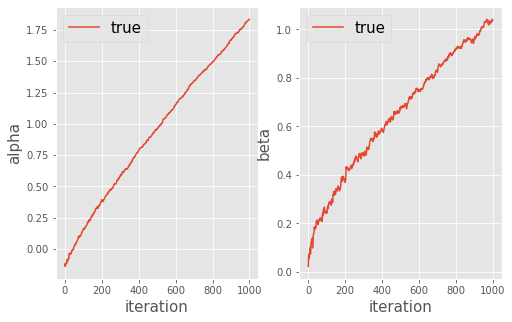

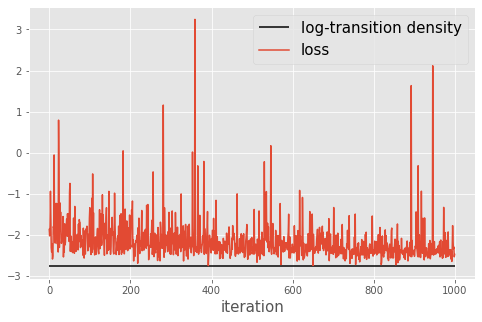

In [276]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
# plt.hlines(float(alpha), 0, niter, color="black")
plt.plot(output["params"]["alpha"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("alpha", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.subplot(1, 2, 2)
# plt.hlines(float(beta), 0, niter, color="black")
plt.plot(output["params"]["beta"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("beta", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.figure(figsize=(8, 5))
plt.hlines(float(log_transition_density(T, XT, X0)), 0, niter, color="black")
plt.plot(output["loss"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.legend(["log-transition density", "loss"], fontsize=15)

In [308]:
N = 2**10
proposal_drift = lambda t, x: diffusion.f(t, x) + diffusion.Sigma * output[
    "auxiliary"
].grad_logh(XT, t, x)
with torch.no_grad():
    simulation_output = diffusion.simulate_proposal_bridge(
        proposal_drift, X0, XT, N, modify=False
    )
    trajectories = simulation_output["trajectories"]
    log_proposal = simulation_output["logdensity"]
log_target = diffusion.law_bridge(trajectories)
log_weights = log_target - log_proposal
# log_weights = output["auxiliary"].log_radon_nikodym(trajectories)

# importance sampling
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
print("log-transition density:", float(log_transition_density(T, XT, X0)))
print("IS log-transition estimate:", float(log_transition_estimate))
print("ESS%:", float(ess * 100 / N))

# independent Metropolis-Hastings
with torch.no_grad():
    initial = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, 1)
    current_trajectory = initial["trajectories"]
    current_log_proposal = initial["logdensity"]
current_log_target = diffusion.law_bridge(current_trajectory)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if torch.log(torch.rand(1)) < log_accept_prob:
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()
        num_accept += 1
accept_rate = num_accept / N
print("IMH acceptance rate:", accept_rate)

log-transition density: -2.760589599609375
IS log-transition estimate: -2.678074598312378
ESS%: 54.084556579589844
IMH acceptance rate: 0.5322265625
